AlphaVantage API Key: 4RAX5IX44VPJZ708


In [12]:
# Load Libraries

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import os
import urllib
import json
import datetime as dt



In [13]:
# API key from Alpha Vantage
api_key = '4RAX5IX44VPJZ708'

# Amazon stock market prices
ticker = "AMZN"

# JSON file with all the stock market data for AMZN from the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# Save file as csv, if not done already
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())

        # Extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                        float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save, index=False)

# If the data is already there, load it from the CSV
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)


File already exists. Loading data from CSV


In [14]:
df.dtypes

Date      object
Low      float64
High     float64
Close    float64
Open     float64
dtype: object

In [15]:
# Parse 'Date' column to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=True)

# Select the 'Close' column and normalize the values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df['Close'].values.reshape(-1, 1))



In [8]:
df.head()

,Low,High,Close,Open
Date,,,,
1999-11-01,66.31,71.88,69.13,68.06
1999-11-02,65.06,70.00,66.44,69.75
1999-11-03,65.00,68.50,65.81,68.19
1999-11-04,61.00,67.19,63.06,67.19
1999-11-05,62.25,65.50,64.94,64.75


In [9]:
# Function to create sequences of data
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences with a window of the last 60 days
sequence_length = 60
X, y = create_sequences(scaled_close, sequence_length)



In [10]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')





In [12]:
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)



Epoch 1/100

151/151 [==============================] - 7s 29ms/step - loss: 7.8522e-04 - val_loss: 0.0029
Epoch 2/100
151/151 [==============================] - 4s 26ms/step - loss: 2.3172e-04 - val_loss: 0.0036
Epoch 3/100
151/151 [==============================] - 4s 27ms/step - loss: 1.8963e-04 - val_loss: 0.0024
Epoch 4/100
151/151 [==============================] - 4s 26ms/step - loss: 1.8100e-04 - val_loss: 0.0050
Epoch 5/100
151/151 [==============================] - 4s 27ms/step - loss: 1.8754e-04 - val_loss: 0.0029
Epoch 6/100
151/151 [==============================] - 4s 26ms/step - loss: 1.5553e-04 - val_loss: 0.0020
Epoch 7/100
151/151 [==============================] - 4s 26ms/step - loss: 1.6276e-04 - val_loss: 0.0031
Epoch 8/100
151/151 [==============================] - 4s 27ms/step - loss: 1.4435e-04 - val_loss: 0.0022
Epoch 9/100
151/151 [==============================] - 4s 26ms/step - loss: 1.7096e-04 - val_loss: 0.0023
Epoch 10/100
151/151 [=======================

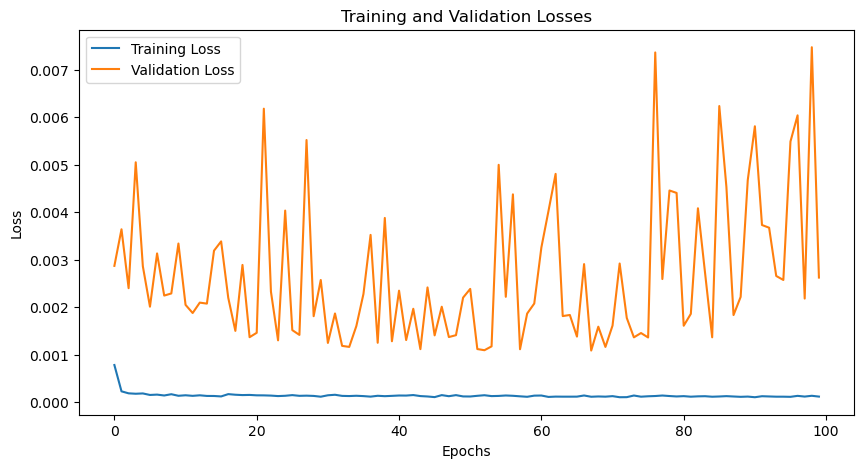

In [13]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Making predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))



38/38 [==============================] - 1s 9ms/step


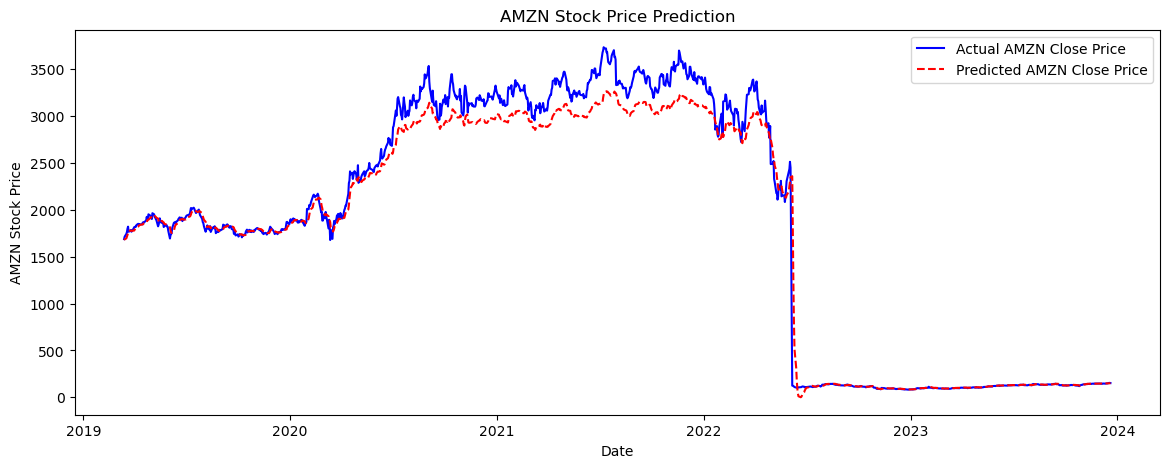

In [15]:
# After making predictions
# ... [Code to make predictions] ...

# Get the last `len(predictions)` dates from the DataFrame for plotting
plot_dates = df.index[-len(predictions):]

# Plotting actual vs. predicted prices
plt.figure(figsize=(14, 5))
plt.plot(plot_dates, y_test_scaled, color='blue', label='Actual AMZN Close Price')
plt.plot(plot_dates, predictions, color='red', linestyle='dashed', label='Predicted AMZN Close Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'predictions' and 'y_test_scaled' are the predicted and actual prices from the test set

# Calculate MAE, MSE, RMSE, and R2
mae = mean_absolute_error(y_test_scaled, predictions)
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)  # Or directly use mean_squared_error(..., squared=False)
r2 = r2_score(y_test_scaled, predictions)

# Print out the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 115.75844751878076
Mean Squared Error (MSE): 36427.459007893296
Root Mean Squared Error (RMSE): 190.85978887102777
R-squared (R2): 0.9793082937597379
